<a href="https://colab.research.google.com/github/DAN-BIWOTT/Arasaka-TradingSystems/blob/main/Ensembled_SVR_%26_SFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install skl2onnx onnxruntime

# Import Data Set

In [37]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re

In [38]:
from google.colab import drive, files
drive.mount('/content/drive') # mount your google colab file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
filename_in_drive = "/content/drive/My Drive/Forex/Market Data GBPUSD before 2025.02.28.csv"
data = pd.read_csv(filename_in_drive)
# Version Number
model_version = "3.1"
# Extract date from filename_in_drive
match = re.search(r'\b(\d{4}\.\d{2}\.\d{2})\b', filename_in_drive)
if match:
    extracted_date = match.group(1)
else:
    print("No date found in the filename.")
data.head(3)

,Time,Open,High,Low,Close,Volume
0,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
1,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
2,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0


In [40]:
num_rows = len(data)
num_rows

99739

In [41]:
data = data[::-1]
# Reduce the dataset to the first 10,000 rows because
data = data.head(10000)
original_data = data.copy()

data.head(3)

,Time,Open,High,Low,Close,Volume
99738,2025.02.27 23:00:00,1.25989,1.26026,1.25920,1.26002,598
99737,2025.02.27 22:00:00,1.26120,1.26124,1.25980,1.26001,1787
99736,2025.02.27 21:00:00,1.26080,1.26120,1.26044,1.26117,4562


In [42]:
num_rows = len(data)
num_rows

10000

In [43]:
data.tail()

,Time,Open,High,Low,Close,Volume
89743,2023.07.20 14:00:00,1.28915,1.28916,1.28543,1.28712,11638
89742,2023.07.20 13:00:00,1.28956,1.29052,1.28913,1.28914,5161
89741,2023.07.20 12:00:00,1.29136,1.29168,1.28892,1.28957,5167
89740,2023.07.20 11:00:00,1.29239,1.29239,1.29079,1.29135,4608
89739,2023.07.20 10:00:00,1.29101,1.29327,1.29089,1.29238,4871


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 99738 to 89739
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    10000 non-null  object 
 1   Open    10000 non-null  float64
 2   High    10000 non-null  float64
 3   Low     10000 non-null  float64
 4   Close   10000 non-null  float64
 5   Volume  10000 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 468.9+ KB


In [45]:
#Define the forecast horizon
look_ahead = 1

In [46]:
#Calculate the median, which is the midpoint between the high and low prices.
data['Candlestick_Median'] = (data['High'] + data['Low']) / 2

data.head()

,Time,Open,High,Low,Close,Volume,Candlestick_Median
99738,2025.02.27 23:00:00,1.25989,1.26026,1.25920,1.26002,598,1.25973
99737,2025.02.27 22:00:00,1.26120,1.26124,1.25980,1.26001,1787,1.26052
99736,2025.02.27 21:00:00,1.26080,1.26120,1.26044,1.26117,4562,1.26082
99735,2025.02.27 20:00:00,1.26282,1.26295,1.26051,1.26079,4645,1.26173
99734,2025.02.27 19:00:00,1.26128,1.26292,1.26126,1.26281,3977,1.26209


In [47]:
data['Candlestick_Median'] = data['Candlestick_Median'].shift(-1)
data = data.rename(columns={'Candlestick_Median': 'Future_Median'})
data['Price_Difference'] = data['High'] - data['Low']
data['Open_Close_Change_Pct'] = (data['Close'] - data['Open']) / data['Open'] * 100
data['High_Low_Change_Pct'] = (data['High'] - data['Low']) / data['Low'] * 100
data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean() # 20-period moving average of volume
data['Volume_Change_Pct'] = data['Volume'].pct_change() * 100 # Percentage change in volume

In [48]:
data.head()

,Time,Open,High,Low,Close,Volume,Future_Median,Price_Difference,Open_Close_Change_Pct,High_Low_Change_Pct,Volume_MA_20,Volume_Change_Pct
99738,2025.02.27 23:00:00,1.25989,1.26026,1.25920,1.26002,598,1.26052,0.00106,0.010318,0.084180,NaN,NaN
99737,2025.02.27 22:00:00,1.26120,1.26124,1.25980,1.26001,1787,1.26082,0.00144,-0.094355,0.114304,NaN,198.829431
99736,2025.02.27 21:00:00,1.26080,1.26120,1.26044,1.26117,4562,1.26173,0.00076,0.029346,0.060296,NaN,155.288193
99735,2025.02.27 20:00:00,1.26282,1.26295,1.26051,1.26079,4645,1.26209,0.00244,-0.160751,0.193572,NaN,1.819377
99734,2025.02.27 19:00:00,1.26128,1.26292,1.26126,1.26281,3977,1.26193,0.00166,0.121305,0.131614,NaN,-14.381055


In [49]:
# Create lagged median prices
data['median_t-1'] = data['Future_Median'].shift(2)
data['median_t-2'] = data['Future_Median'].shift(3)

In [50]:
# Update features (X)
X = data[["Open", "High", "Low", "Close", "Price_Difference", "Open_Close_Change_Pct",
          "High_Low_Change_Pct", "Volume", "Volume_MA_20", "Volume_Change_Pct",
          "median_t-1", "median_t-2"]].copy()
y = data["Future_Median"]  # Target variable

In [51]:
# Removing NAN Values while preserving time series structure
# Creating a temporary DataFrame combining X and y for consistent indexing
temp_df = pd.concat([X, y], axis=1)

# Dropping rows with NaN values in any column (features or target)
temp_df.dropna(inplace=True)

# Extractting updated X and y from the temporary DataFrame
X = temp_df[X.columns]  # Features
y = temp_df[y.name]  # Target variable

 Ensemble an SVR and an SFN

In [52]:
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np

scale

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
print("NaN values in X (features):")
print(X[X.isnull().any(axis=1)])  # Display rows with NaN in X

print("\nNaN values in y (target):")
print(y[y.isnull()])

NaN values in X (features):
Empty DataFrame
Columns: [Open, High, Low, Close, Price_Difference, Open_Close_Change_Pct, High_Low_Change_Pct, Volume, Volume_MA_20, Volume_Change_Pct, median_t-1, median_t-2]
Index: []

NaN values in y (target):
Series([], Name: Future_Median, dtype: float64)


In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}  # Example hyperparameter grid
grid_search = GridSearchCV(LinearSVR(max_iter=10000), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_linear_svr_model = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SFN with Grid search

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# Define the hyperparameter grid for the SFN (MLPRegressor)
param_grid_sfn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Create GridSearchCV object for the SFN
grid_search_sfn = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42),
                               param_grid_sfn, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search_sfn.fit(X_train, y_train)

# Get the best SFN model
best_sfn_model = grid_search_sfn.best_estimator_

print("Best SFN Model:")
print(best_sfn_model)

Best SFN Model:
MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 50),
             max_iter=1000, random_state=42)


Temporary SFN without Grid search

In [58]:
# from sklearn.neural_network import MLPRegressor

# # Define the SFN model with pre-selected hyperparameters
# best_sfn_model = MLPRegressor(
#     hidden_layer_sizes=(100,),  # Example: Using one hidden layer with 100 neurons
#     activation='relu',        # Example: Using ReLU activation function
#     solver='adam',            # Example: Using the Adam optimizer
#     alpha=0.001,             # Example: Setting regularization strength
#     learning_rate='constant', # Example: Using a constant learning rate
#     max_iter=1000,           # Maximum number of iterations
#     random_state=42          # For reproducibility
# )

# # Fit the SFN model to the training data
# best_sfn_model.fit(X_train, y_train)

# print("SFN Model:")
# print(best_sfn_model)

In [59]:
ensemble_model = VotingRegressor(estimators=[('linear_svr', best_linear_svr_model), ('sfn', best_sfn_model)],
                                 weights=[0.7, 0.3])  # Example: 0.7 for LinearSVR, 0.3 for SFN
ensemble_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingRegressor(estimators=[('linear_svr',
                             LinearSVR(C=10, epsilon=0.01, max_iter=10000)),
                            ('sfn',
                             MLPRegressor(activation='tanh', alpha=0.01,
                                          hidden_layer_sizes=(100, 50),
                                          max_iter=1000, random_state=42))],
                weights=[0.7, 0.3])

In [60]:
# Evaluate the ensemble model
y_pred = ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of Ensemble: {mse}")

Mean Squared Error of Ensemble: 5.798586736326748e-05


Graph the perfomance

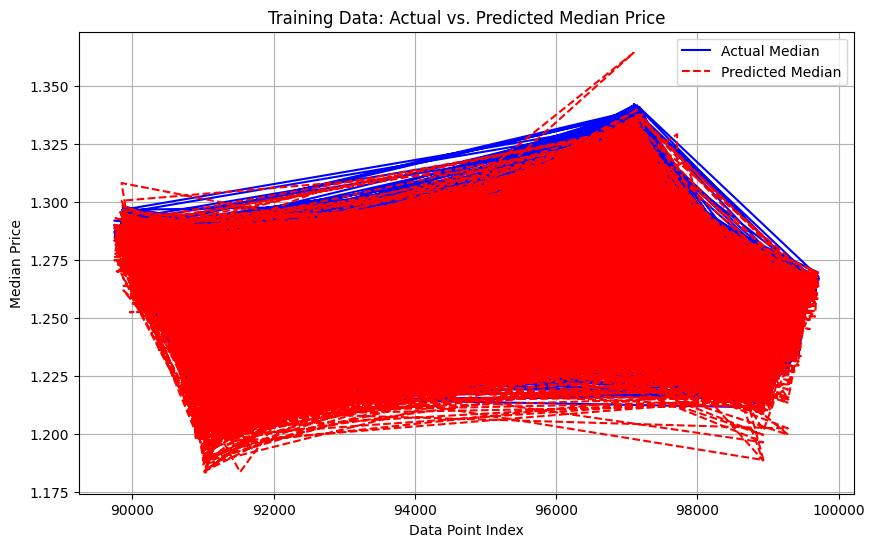

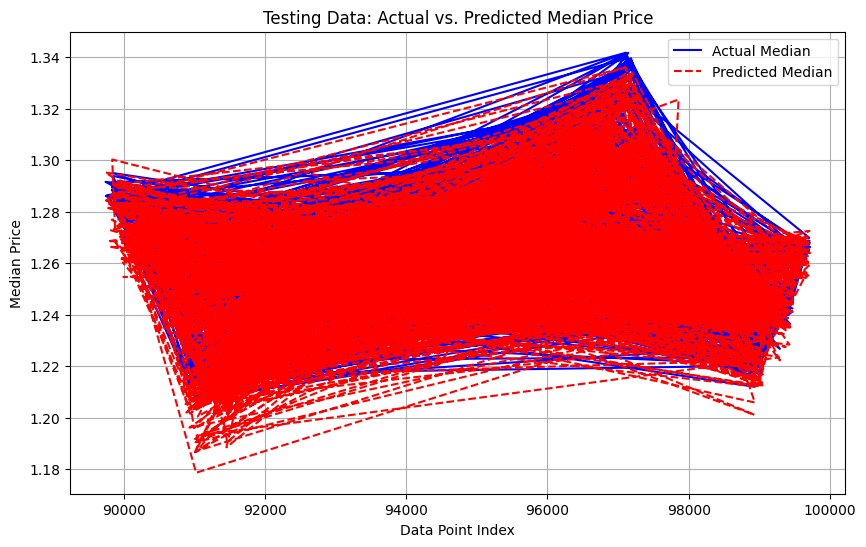

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Predictions (Same as before)
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# 2. Training Data Performance
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Actual Median', color='blue')  # Actual median in blue
plt.plot(y_train.index, y_train_pred, label='Predicted Median', color='red', linestyle='--')  # Predicted median in dashed red
plt.title('Training Data: Actual vs. Predicted Median Price')
plt.xlabel('Data Point Index')
plt.ylabel('Median Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. Testing Data Performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Median', color='blue')  # Actual median in blue
plt.plot(y_test.index, y_test_pred, label='Predicted Median', color='red', linestyle='--')  # Predicted median in dashed red
plt.title('Testing Data: Actual vs. Predicted Median Price')
plt.xlabel('Data Point Index')
plt.ylabel('Median Price')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
import json
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# 1. Calculate Performance Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_explained_variance = explained_variance_score(y_train, y_train_pred)
test_explained_variance = explained_variance_score(y_test, y_test_pred)

# 2. Store Metrics in a Dictionary
performance_metrics = {
    "train_mse": train_mse,
    "test_mse": test_mse,
    "train_rmse": train_rmse,
    "test_rmse": test_rmse,
    "train_mae": train_mae,
    "test_mae": test_mae,
    "train_r2": train_r2,
    "test_r2": test_r2,
    "train_explained_variance": train_explained_variance,
    "test_explained_variance": test_explained_variance
}

# 3. Get Features and Model Name
features = list(X.columns)
model_name = f"{model_version}_Ensemble Model (Linear SVR + SFN)_{extracted_date}"  # Update model name

# 4. (Optional) Scaling Parameters - If you used scaling, include this part
scaling_parameters = {
    "mean": scaler.mean_.tolist(),
    "std_dev": scaler.scale_.tolist()
}

# 5. Create Log Data Dictionary
log_data = {
    "model_name": model_name,
    "features": features,
    "performance_metrics": performance_metrics,
    "scaling_parameters": scaling_parameters  # Include if you have scaling parameters
}

# 6. Save to JSON File
# Assuming 'extracted_date' is defined earlier in your code
with open(f"{model_name}_log_{extracted_date}.json", "w") as f:
    json.dump(log_data, f, indent=4)

print(f"{model_version}_Model log saved to {model_name}_log_{extracted_date}.json")

3.1_Model log saved to 3.1_Ensemble Model (Linear SVR + SFN)_2025.02.28_log_2025.02.28.json


In [63]:
print("Scaling Mean:", ', '.join(map(str, scaler.mean_)))
print("Scaling Standard Deviation:", ', '.join(map(str, scaler.scale_)))

Scaling Mean: 1.2670671355210419, 1.267835398296593, 1.266276118486974, 1.2670707790581162, 0.0015592798096192375, 0.0003243208535799474, 0.12336471175124646, 3251.81751002004, 3254.8220879258515, 13.345331769862147, 1.2670541526803607, 1.2670533648547095
Scaling Standard Deviation: 0.026336650708466143, 0.026292642481576575, 0.026371460537164326, 0.026340337776548116, 0.001110068612524553, 0.09232191644423246, 0.0883733577125588, 3522.6517528536338, 2283.8814311439114, 92.92685456526189, 0.026329045609664467, 0.026327734629925145


ONNX file Generation

In [64]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

In [65]:
initial_type = [('input', FloatTensorType([None, X_test.shape[1]]))]  # Define input shape based on your features

In [66]:
# Convert weights to a NumPy array before converting to ONNX
ensemble_model.weights = np.array(ensemble_model.weights)

initial_type = [('input', FloatTensorType([None, X_test.shape[1]]))]  # Define input shape based on your features
onnx_model = convert_sklearn(ensemble_model, initial_types=initial_type)
with open(f"{model_version}_ensemble_model_{extracted_date}.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())